# Dissimilarity Metric-based Channel Charting

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
from sklearn.manifold import trustworthiness
from scipy.spatial import distance_matrix

## Training Set

In [2]:
# time domain CSI
csi_time_domain = np.load('dataset/csi_time_domain_train.npy')

# ground truth positions
groundtruth_positions = np.load('dataset/groundtruth_positions_train.npy')

# dissimilarity matrix
dissimilarity_matrix_geodesic = np.load("results/dissimilarity_matrix_geodesic.npy")

## Manifold Learning: Finding the Low-Dimensional Representation

In [3]:
class FeatureEngineeringLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

    def call(self, csi):
        # Compute sample autocorrelations for any combination of two antennas in the whole system
        # for the same datapoint and time tap.
        # csi has shape (batchsize, array, antenna row, antenna column, tap)
        sample_autocorrelations = tf.einsum("darmt,dbsnt->dtabrmsn", csi, tf.math.conj(csi))
        return tf.stack([tf.math.real(sample_autocorrelations), tf.math.imag(sample_autocorrelations)], axis = -1)

In [4]:
csi_time_domain_tensor = tf.constant(csi_time_domain)
dissimilarity_matrix_geodesic_tensor = tf.constant(dissimilarity_matrix_geodesic, dtype = tf.float32)

datapoint_count = tf.shape(csi_time_domain_tensor)[0].numpy()

random_integer_pairs_dataset = tf.data.Dataset.zip(tf.data.Dataset.random(), tf.data.Dataset.random())

@tf.function
def fill_pairs(randA, randB):
    return (csi_time_domain_tensor[randA % datapoint_count], csi_time_domain_tensor[randB % datapoint_count]), dissimilarity_matrix_geodesic_tensor[randA % datapoint_count, randB % datapoint_count]

random_pair_dataset = random_integer_pairs_dataset.map(fill_pairs)

### The Forward Charting Function: Defining the Neural Network

In [5]:
array_count = np.shape(csi_time_domain)[1]
rows_per_array_count = np.shape(csi_time_domain)[2]
antennas_per_row_count = np.shape(csi_time_domain)[3]
tap_count = np.shape(csi_time_domain)[4]

cc_embmodel_input = tf.keras.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count), name="input", dtype = tf.complex64)
cc_embmodel_output = FeatureEngineeringLayer()(cc_embmodel_input)
cc_embmodel_output = tf.keras.layers.Flatten()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(1024, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(512, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(256, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(128, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(64, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(2, activation = "linear")(cc_embmodel_output)

cc_embmodel = tf.keras.Model(inputs = cc_embmodel_input, outputs = cc_embmodel_output, name = "ForwardChartingFunction")

In [6]:
input_A = tf.keras.layers.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count,), dtype = tf.complex64)
input_B = tf.keras.layers.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count,), dtype = tf.complex64)

embedding_A = cc_embmodel(input_A)
embedding_B = cc_embmodel(input_B)

output = tf.keras.layers.concatenate([embedding_A, embedding_B], axis=1)
model = tf.keras.models.Model([input_A, input_B], output, name = "SiameseNeuralNetwork")
model.summary()

Model: "SiameseNeuralNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4, 2, 4, 13)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4, 2, 4, 13)]        0         []                            
                                                                                                  
 ForwardChartingFunction (F  (None, 2)                    2796934   ['input_1[0][0]',             
 unctional)                                               6          'input_2[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 4)                    0         ['ForwardCh

In [7]:
dissimilarity_margin = np.quantile(dissimilarity_matrix_geodesic, 0.01)

def siamese_loss(y_true, y_pred):
    y_true = y_true[:,0]
    pos_A, pos_B = (y_pred[:,:2], y_pred[:,2:])
    distances_pred = tf.math.reduce_euclidean_norm(pos_A - pos_B, axis = 1)

    return tf.reduce_mean(tf.square(distances_pred - y_true) / (y_true + dissimilarity_margin))

### Training

In [8]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = siamese_loss, optimizer = optimizer)

samples_per_session = 150000
learning_rates = [1e-2, 1e-2, 8e-3, 4e-3, 1e-3, 5e-4, 2e-4, 1e-4]
batch_size = [500, 1000, 1500, 2000, 3000, 4000, 5000, 6000]

for l in range(len(learning_rates)):
    print("\nTraining Session ", l + 1, "\nBatch Size: ", batch_size[l], "\nLearning rate: ", learning_rates[l])
    
    # Fit model
    optimizer.learning_rate.assign(learning_rates[l])
    model.fit(random_pair_dataset.batch(batch_size[l]).prefetch(tf.data.AUTOTUNE), steps_per_epoch = samples_per_session // batch_size[l])


Training Session  1 
Batch Size:  500 
Learning rate:  0.01
300/300 [==============================] - 12s 24ms/step - loss: 50.0482

Training Session  2 
Batch Size:  1000 
Learning rate:  0.01
150/150 [==============================] - 6s 38ms/step - loss: 2.9424

Training Session  3 
Batch Size:  1500 
Learning rate:  0.008
100/100 [==============================] - 5s 52ms/step - loss: 2.5631

Training Session  4 
Batch Size:  2000 
Learning rate:  0.004
75/75 [==============================] - 5s 65ms/step - loss: 2.3818

Training Session  5 
Batch Size:  3000 
Learning rate:  0.001
50/50 [==============================] - 5s 92ms/step - loss: 2.2638

Training Session  6 
Batch Size:  4000 
Learning rate:  0.0005
37/37 [==============================] - 5s 120ms/step - loss: 2.2423

Training Session  7 
Batch Size:  5000 
Learning rate:  0.0002
30/30 [==============================] - 5s 149ms/step - loss: 2.2070

Training Session  8 
Batch Size:  6000 
Learning rate:  0.0001
25/

# Evaluation

In [9]:
def plot_colorized(positions, reference_positions, title = None, show = True, alpha = 1.0):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(reference_positions[:, 0], axis = 0) + np.max(reference_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(reference_positions[:, 1], axis = 0) + np.max(reference_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((reference_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(reference_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(reference_positions[:,:2] - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(reference_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(6, 6))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    if show:
        plt.show()

def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond = None)
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

def plot_cdf(positions, reference_positions, title = None):
    errorvectors = reference_positions[:,:2] - positions
    errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
    count, bins_count = np.histogram(errors, bins=200)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    bins_count[0] = 0
    cdf = np.append([0], cdf)

    plt.figure(figsize=(5, 4))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.plot(bins_count, cdf)
    plt.xlim((0, 2))
    plt.xlabel("Absolute Localization Error [m]")
    plt.ylabel("CDF")
    plt.grid()
    plt.show()

# Continuity is identical to trustworthiness, except that original space and embedding space are swapped
def continuity(*args, **kwargs):
    args = list(args)
    args[0], args[1] = args[1], args[0]
    return trustworthiness(*args, **kwargs)

def kruskal_stress(X, X_embedded):
    dist_X = distance_matrix(X, X)
    dist_X_embedded = distance_matrix(X_embedded, X_embedded)
    beta = np.divide(np.sum(dist_X * dist_X_embedded), np.sum(dist_X_embedded * dist_X_embedded))

    return np.sqrt(np.divide(np.sum(np.square((dist_X - beta * dist_X_embedded))), np.sum(dist_X * dist_X)))

## Evaluate on Training Set

651/651 [==============================] - 1s 2ms/step


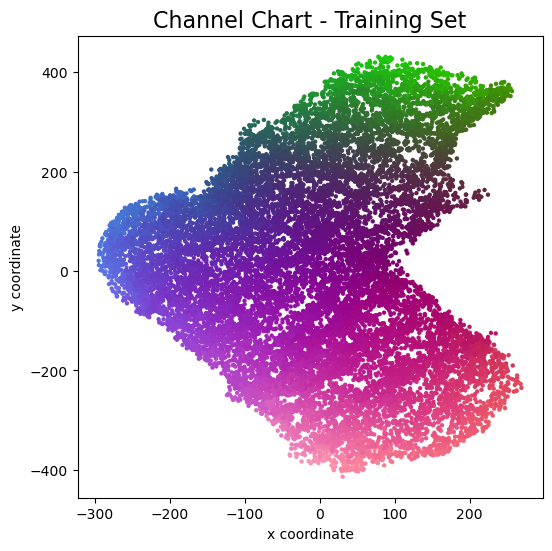

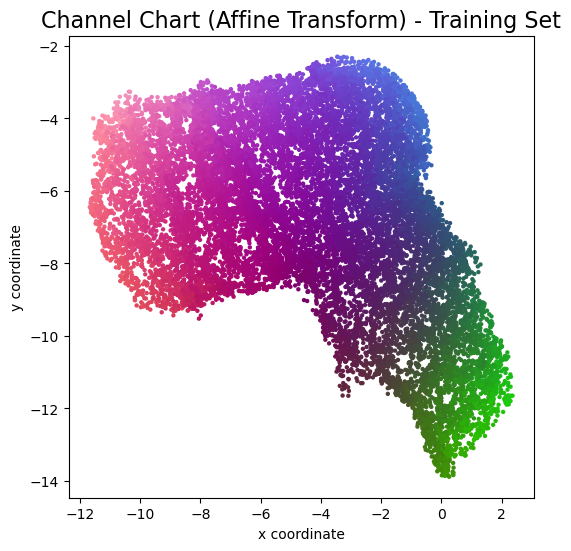

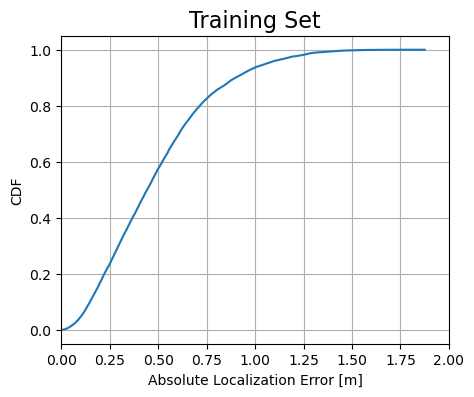

In [10]:
channel_chart_positions = cc_embmodel.predict(csi_time_domain_tensor)
plot_colorized(channel_chart_positions, groundtruth_positions, title = "Channel Chart - Training Set")

channel_chart_positions_transformed = affine_transform_channel_chart(groundtruth_positions, channel_chart_positions)
plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "Channel Chart (Affine Transform) - Training Set")

plot_cdf(channel_chart_positions_transformed, groundtruth_positions, title = "Training Set")

In [11]:
# Evaluate CT / TW / KS on a subset of the whole dataset
subset_indices = random.sample(range(len(groundtruth_positions)), len(groundtruth_positions) // 5)
groundtruth_positions_subset = groundtruth_positions[subset_indices]
channel_chart_positions_subset = channel_chart_positions[subset_indices]
channel_chart_positions_transformed_subset = channel_chart_positions_transformed[subset_indices]

errorvectors = groundtruth_positions_subset - channel_chart_positions_transformed_subset
errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.mean(errors)

ct = continuity(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
tw = trustworthiness(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
ks = kruskal_stress(groundtruth_positions_subset, channel_chart_positions_subset)

print("MAE: {}m \nCT: {} \nTW: {} \nKS: {}".format(*np.around((mae, ct, tw, ks), 4)))

MAE: 0.4864m 
CT: 0.9966 
TW: 0.9965 
KS: 0.0831


In [12]:
# save channel chart positions
np.save("results/channel_chart_positions_train.npy", channel_chart_positions)

## Evaluate on Prediction Set

In [13]:
csi_time_domain_pred = np.load('dataset/csi_time_domain_pred.npy')
groundtruth_positions_pred = np.load('dataset/groundtruth_positions_pred.npy')

In [14]:
csi_time_domain_pred_tensor = tf.constant(csi_time_domain_pred)

652/652 [==============================] - 1s 2ms/step


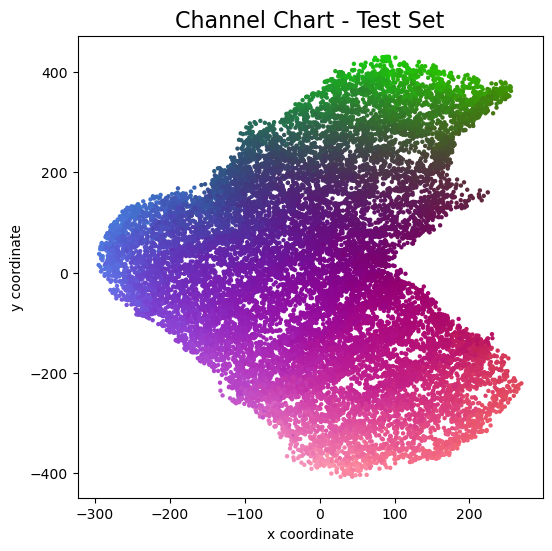

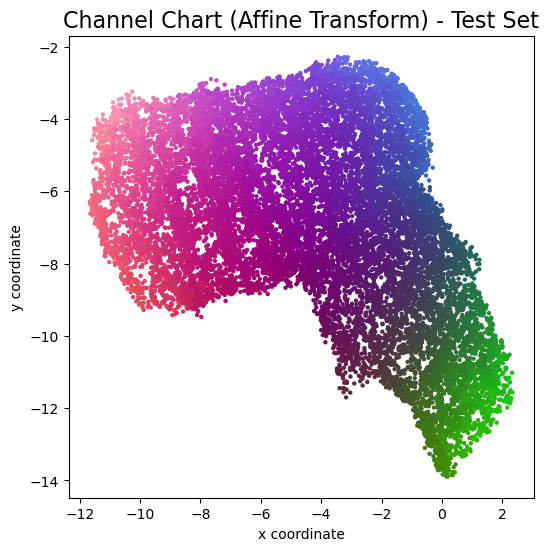

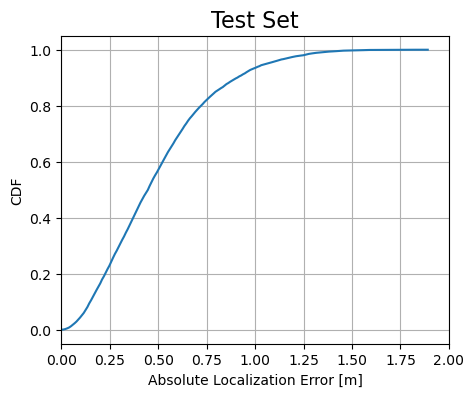

In [15]:
channel_chart_positions_pred = cc_embmodel.predict(csi_time_domain_pred_tensor)
plot_colorized(channel_chart_positions_pred, groundtruth_positions_pred, title = "Channel Chart - Prediction Set")

channel_chart_positions_pred_transformed = affine_transform_channel_chart(groundtruth_positions_pred, channel_chart_positions_pred)
plot_colorized(channel_chart_positions_pred_transformed, groundtruth_positions_pred, title = "Channel Chart (Affine Transform) - Prediction Set")

plot_cdf(channel_chart_positions_pred_transformed, groundtruth_positions_pred, title = "Prediction Set")

In [16]:
# Evaluate CT / TW / KS on a subset of the whole dataset
subset_indices = random.sample(range(len(groundtruth_positions_pred)), len(groundtruth_positions_pred) // 5)
groundtruth_positions_pred_subset = groundtruth_positions_pred[subset_indices]
channel_chart_positions_pred_subset = channel_chart_positions_pred[subset_indices]
channel_chart_positions_pred_transformed_subset = channel_chart_positions_pred_transformed[subset_indices]

errorvectors = groundtruth_positions_pred_subset - channel_chart_positions_pred_transformed_subset
errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.mean(errors)

ct = continuity(groundtruth_positions_pred_subset, channel_chart_positions_pred_subset, n_neighbors = int(0.05 * len(groundtruth_positions_pred_subset)))
tw = trustworthiness(groundtruth_positions_pred_subset, channel_chart_positions_pred_subset, n_neighbors = int(0.05 * len(groundtruth_positions_pred_subset)))
ks = kruskal_stress(groundtruth_positions_pred_subset, channel_chart_positions_pred_subset)

print("MAE: {}m \nCT: {} \nTW: {} \nKS: {}".format(*np.around((mae, ct, tw, ks), 4)))

MAE: 0.4986m 
CT: 0.9965 
TW: 0.9964 
KS: 0.0847


In [17]:
# save channel chart positions
np.save("results/channel_chart_positions_pred.npy", channel_chart_positions_pred)